<a href="https://colab.research.google.com/github/matheus-cmc/atividades_IA_industrial/blob/main/Atividade_4_S%C3%ADncrona_3_Implanta%C3%A7%C3%A3o_e_infer%C3%AAncia_com_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#1)Importações

import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib # Salvar e carregar o pipeline(Implatação)

#Ferramentas do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

#Métricas de avaliação

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score
)

from xgboost import XGBClassifier

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [11]:
#2) Funções Auxiliares

def carregar_csv(nome_arquivo="flights_delays_120.csv"):
  """
    Carrega o arquivo CSV informado.
    Verifica se o arquivos existe antes de tentar ler.
  """
  if os.path.exists(nome_arquivo):
    print(f"Arquivo '{nome_arquivo}' encontrado. Carregando dados...")
    return pd.read_csv(nome_arquivo)
  else:
    print(f"ERRO: Arquivo '{nome_arquivo}' não encontrado.")
    raise FileNotFoundError(f"Arquivo '{nome_arquivo}' não encontrado.")

def coluna_alvo(dados):
  """
  Detectar automaticamente a coluna alvo do dataFrame.
  Procurar por nomes comuns de colunas alvo.
  """
  candidatos = ["delayed", "atrasos", "alvo", "target", "y"]

  for c in candidatos:
    if c in dados.columns:
      print(f"Coluna alvo detectada: '{c}'")
      return c

  print("ERRO: Nenhuma coluna alvo (como 'delayed' ou 'atraso') foi encontrada.")
  raise KeyError("Coluna alvo não encontrada.")

def prev_avaliar(pipeline, X_data, y_true, nome_conjunto="Teste", threshold=0.5):
  """
  Função auxiliar para fazer predições e exibir métricas de desempenho.
  """
  print(f"\n---- Avalição no conjunto de {nome_conjunto} ----")

  #Obter probabilidades
  probas = pipeline.predict_proba(X_data)[:,1]

  #Converter para classe binária
  y_pred = (probas >= threshold).astype(int)

  #Matriz de confusão
  cm = confusion_matrix(y_true, y_pred)
  print("Matriz de confusão:\n", cm)

  #Métricas principais
  print(f"Acurária:{accuracy_score(y_true, y_pred):.4f}")
  print(f"Precisão: {precision_score(y_true, y_pred, zero_division=0):.4f}")
  print(f"Recall (Sensibilidade): {recall_score(y_true,y_pred, zero_division=0):.4f} ")
  print(f"F1-Score: {f1_score(y_true, y_pred, zero_division=0):.4f}")

  #Relatório de Classificação

  print("\nRelatório de Classificação:\n", classification_report(y_true,y_pred))

  auc = roc_auc_score(y_true, probas)
  print(f"AUC (Área sob Curva): {auc:.4f}")

  #Retornar o AUC para classificação
  return auc


In [12]:
#3) Carregar e Preparar os dados

#3.1) Carregar dados
dados = carregar_csv()
alvo = coluna_alvo(dados)

#Separar X (features) e y (alvo)
y = dados[alvo]
x = dados.drop(columns=[alvo])

#Separa as colunas categóricas de numéricas

cat = [c for c in x.columns if x[c].dtype == "object"]
num = [c for c in x.columns if c not in cat]
print (f"Colunas categóricas identificadas:{cat}")
print (f"Colunas numéricas identificadas:{num}")

#Dividir em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(
    x, y,
    test_size=0.25,
    stratify = y,
    random_state = 7
)
print(f"Dados divididos: {len(y_treino)} para treino, {len(y_teste)} para teste.")

#4) Pré-processador e pipeline do modelo

preprocessador = ColumnTransformer([
    ("categoricas", OneHotEncoder(handle_unknown="ignore"), cat),
    ("numericas", "passthrough", num)
])

#Modelo XGBoost
modelo = XGBClassifier(
    n_estimators = 300, # Define o número de árvores de decisão a serem construídas sequencialmente (rodadas de boosting).
    learning_rate = 0.08, # Controla o peso dado a cada nova árvore, ou seja, a taxa na qual o modelo aprende.
    max_depth = 6, # Define a profundidade máxima de cada árvore individual no conjunto.
    subsample = 0.9, # Fração das amostras de treinamento (linhas) a serem usadas para construir cada árvore. Usar 90% (0.9) dos dados de forma aleatória ajuda a reduzir a variância do modelo (semelhante ao bagging).
    colsample_bytree=0.9, # Fração das features/variáveis (colunas) a serem amostradas aleatoriamente para construir cada árvore.
    eval_metric = "logloss", # Métrica de avaliação usada para monitorar o desempenho durante o treinamento (especialmente em validação cruzada).
    random_state = 7 # Define a semente para o gerador de números aleatórios.
)

#Criar e treinar o Pipeline
pipeline = Pipeline([
    ("prep", preprocessador),
    ("xgb", modelo)
])

#Treinar
print("\nIniciando o treinamento do modelo XGBoost...")
pipeline.fit(x_treino, y_treino)
print("Modelo treinado com sucesso!")

Arquivo 'flights_delays_120.csv' encontrado. Carregando dados...
Coluna alvo detectada: 'delayed'
Colunas categóricas identificadas:['airline', 'origin', 'destination', 'weather']
Colunas numéricas identificadas:['departure_hour', 'day_of_week']
Dados divididos: 90 para treino, 30 para teste.

Iniciando o treinamento do modelo XGBoost...
Modelo treinado com sucesso!



---- Avalição no conjunto de Teste ----
Matriz de confusão:
 [[17  0]
 [ 0 13]]
Acurária:1.0000
Precisão: 1.0000
Recall (Sensibilidade): 1.0000 
F1-Score: 1.0000

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

AUC (Área sob Curva): 1.0000


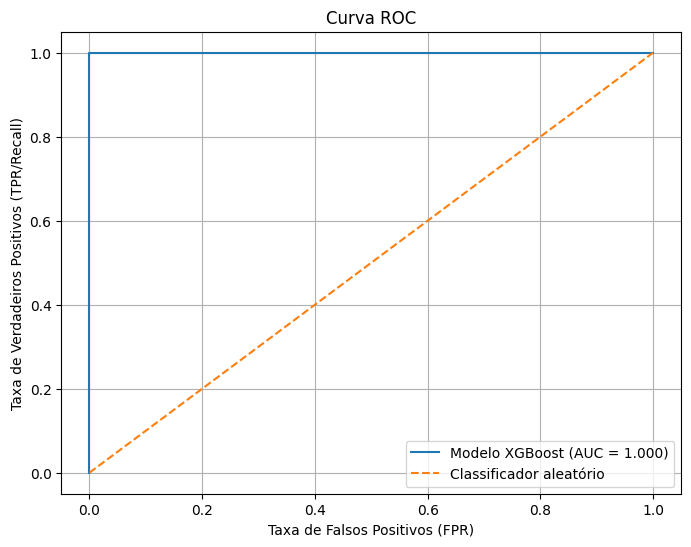

In [13]:
#5) Predições e métricas de desempenho

#Usar a função auxiliar para avaliar o desempenho do conjunto de teste.
auc_teste = prev_avaliar(pipeline, x_teste, y_teste, nome_conjunto="Teste")

#6) Curva ROC e AUC

#Plotar a curva ROC(código mantido da métrica)
probas = pipeline.predict_proba(x_teste)[:,1]
fpr, tpr, thresholds = roc_curve(y_teste, probas)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,label=f"Modelo XGBoost (AUC = {auc_teste:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Classificador aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR/Recall)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#7) Salvar o modelo (Implantação)
nome_arquivo_modelo = "modelo_xgboost_pipeline.joblib"

#Salvar o pipeline completo(pré-processador + modelo)

try:
  joblib.dump(pipeline, nome_arquivo_modelo)
  print(f"\nPipeline completo salvo com sucesso em '{nome_arquivo_modelo}'")

  #Carregar o modelo salvo para simular um ambiente de produção
  modelo_implantado = joblib.load(nome_arquivo_modelo)
  print(f"Modelo carregado(simulação de implantação): {modelo_implantado}")
except Exception as e:
  print(f"Erro ao salvar/carregar o modelo: {e}")
  #Define o modelo implantado como o pipeline treinado se o salvamento falhar
  modelo_implantado = pipeline


Pipeline completo salvo com sucesso em 'modelo_xgboost_pipeline.joblib'
Modelo carregado(simulação de implantação): Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('categoricas',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['airline', 'origin',
                                                   'destination', 'weather']),
                                                 ('numericas', 'passthrough',
                                                  ['departure_hour',
                                                   'day_of_week'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9...
                               feature_types=None, feature_weights=None,
                          

In [15]:
#8) Simular predição em tempo real

#Selecionar um registro aleatório do conjunto de teste para simular entrada

registro_novo = x_teste.sample(1, random_state=42).copy()
y_real = y_teste.loc[registro_novo.index[0]] # valor real do registro

#Fazer a predição

probas_rt = modelo_implantado.predict_proba(registro_novo)[:, 1]
predicao_rt = (probas_rt[0] >= 0.5).astype(int)

#Exibir os resultados
print(f"\nProbabilidade de atraso (Classe 1): {probas_rt[0]:.4f}")
print(f"Predição Binária: {'Atraso' if predicao_rt == 1 else 'No Atraso'} (Valor: {y_real})")
print(f"Predição Correta? {predicao_rt == y_real}")



Probabilidade de atraso (Classe 1): 0.0332
Predição Binária: No Atraso (Valor: 0)
Predição Correta? True


In [16]:
#9) Simular indferência em Lote(Conjunto de Registros)

#Selecionar os primeiros 100 registros do conjunto de teste como 'Lote'
lote_registros = x_teste.head(100).copy()
lote_y_reais = y_teste.head(100).copy()

print("\n--- Inferência em Lote (100 registros) ---")
print(f"Processando lote de {len(lote_registros)} registros...")

#Fazer as predições
# O método 'predict_proba' é vetorizado (rápido) para conjuntos grandes
probas_batch = modelo_implantado.predict_proba(lote_registros)[:,1]
predicoes_batch = (probas_batch >= 0.5).astype(int)

#Analise de Resultados do Lote
df_resultados_batch = pd.DataFrame({
    'Prob_Atraso': probas_batch,
    'Predicao_Binaria': predicoes_batch,
    'Real':lote_y_reais.values
})

#Exibir o resumo e avaliação
acuracia_batch = accuracy_score(df_resultados_batch['Real'], df_resultados_batch['Predicao_Binaria'])
print(f"\nResumo da Inferência em Lote:")
print(f"Acurácia do Lote: {acuracia_batch:.4f}")
print("Distribuição de Predições (0=No Atraso):\n", df_resultados_batch['Predicao_Binaria'].value_counts())
print("\nPrimeiros 5 resultados do Lote:\n", df_resultados_batch.head())


--- Inferência em Lote (100 registros) ---
Processando lote de 30 registros...

Resumo da Inferência em Lote:
Acurácia do Lote: 1.0000
Distribuição de Predições (0=No Atraso):
 Predicao_Binaria
0    17
1    13
Name: count, dtype: int64

Primeiros 5 resultados do Lote:
    Prob_Atraso  Predicao_Binaria  Real
0     0.056706                 0     0
1     0.833625                 1     1
2     0.075693                 0     0
3     0.947199                 1     1
4     0.948816                 1     1


In [17]:
#10) Comparação e conclusão

print("\n\n##################################")
print("### CONCLUSÕES DA IMPLANTAÇÃO E INFERÊNCIA ###")
print("##################################")

# 10.1) Comparação Tempo Real vs. Batch
print("\n1. Consistência entre Tempo Real e Lote:")
print("- A *lógica* de predição é idêntica para os dois modos, pois ambos usam o mesmo Pipeline.")
print("- A principal diferença é a *velocidade* e o *formato* de entrada/saída.")
print("  - **Tempo Real:** Recebe 1 registro, retorna 1 predição. Requer baixa latência (rápido).")
print("  - **Lote:** Recebe N registros, retorna N predições. Focado em *throughput* (alto volume).")
print("- A acurácia do lote (100 registros): {:.4f} (Em linha com o desempenho geral do Teste).".format(acuracia_batch))

# 10.2) Interpretação do Modelo e Métricas
print("\n2. Interpretação das Métricas de Teste:")
print(f"- **AUC ({auc_teste:.4f}):** Um valor alto (próximo de 1) indica que o modelo tem uma excelente capacidade de ranquear corretamente as instâncias (separar voos com e sem atraso).")
print("- **Recall (Sensibilidade):** Indica a proporção de voos *reais* atrasados que o modelo conseguiu capturar. Um Recall alto é crucial se a prioridade for evitar a perda de atrasos.")
print("- **Precisão:** Indica a proporção de voos que o modelo *previu* como atrasados que de fato atrasaram. Uma Precisão alta reduz o número de 'alarmes falsos'.")
print("- O F1-Score busca um equilíbrio entre Precisão e Recall.")

# 10.3) Conclusões da Atividade
print("\n3. Resumo da Atividade (Google Colab):")
print("- A utilização do `Pipeline` do Scikit-learn simplificou o processo de `fit` e `transform`, aplicando o pré-processamento e o modelo em uma única etapa.")
print("- O salvamento via `joblib.dump` garantiu que todo o fluxo (pré-processador e XGBoost) fosse salvo, garantindo a reprodutibilidade na fase de implantação.")
print("- O processo de inferência foi validado em ambos os cenários, mostrando que o modelo implantado está pronto para uso em produção.")
print("##################################")



##################################
### CONCLUSÕES DA IMPLANTAÇÃO E INFERÊNCIA ###
##################################

1. Consistência entre Tempo Real e Lote:
- A *lógica* de predição é idêntica para os dois modos, pois ambos usam o mesmo Pipeline.
- A principal diferença é a *velocidade* e o *formato* de entrada/saída.
  - **Tempo Real:** Recebe 1 registro, retorna 1 predição. Requer baixa latência (rápido).
  - **Lote:** Recebe N registros, retorna N predições. Focado em *throughput* (alto volume).
- A acurácia do lote (100 registros): 1.0000 (Em linha com o desempenho geral do Teste).

2. Interpretação das Métricas de Teste:
- **AUC (1.0000):** Um valor alto (próximo de 1) indica que o modelo tem uma excelente capacidade de ranquear corretamente as instâncias (separar voos com e sem atraso).
- **Recall (Sensibilidade):** Indica a proporção de voos *reais* atrasados que o modelo conseguiu capturar. Um Recall alto é crucial se a prioridade for evitar a perda de atrasos.
- **Precisão